**PROBABILITY DENSITY FUNCTION**

This code bins the particle positions into histograms at each timestep using np.histogram2D.
The result is a heat map of the cumulative particle density over time which, when normalised by the total number of particle positions, yields a probability map.

-Author: Jimena Medina Rubio

-Created on: 18/03/2023

**0. Imports and package versions**

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean
import cmocean.cm as cmo
import pandas as pd

**1. Loading the data**

In [2]:
#select path of directory
path="/Users/lienzo/Desktop/Thesis/Parcelscodes/"

#import OceanParcels output in netCDF
file="toy_data_01.nc"

ds=xr.open_dataset(path+file)
print(ds.keys)

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical>


**2. DEFINITION OF FUNCTIONS**

In [3]:
def probability_density(ds, bins_x, bins_y):
    
    """
    Calculates the PDF of the longitude and latitude coordinates of the trajectories at each observation.
    
    Input variables
    -ds: OceanParcels output of lon & lat of each particle at each timestep
    -bins_x & bins_y: number of bins in x/y direction 
    """

    def histogram(lon, lat, bins_x, bins_y): 
        
        #define the coordinates of the edges of the bins
        bins_edges_x = np.histogram_bin_edges(lon, bins=bins_x)
        bins_edges_y = np.histogram_bin_edges(lat, bins=bins_y)
        
        #calculate the 2D normalised histogram & bin edges
        H, x, y = np.histogram2d(lon.flatten(), lat.flatten(), bins=[bins_edges_x, bins_edges_y], density=True)
        return H, x, y
    
    #apply histogram function to all trajectories at every observation
    result = xr.apply_ufunc(
        histogram,
        ds['lon'].values,
        ds['lat'].values,
        bins_x,
        bins_y,
        input_core_dims=[['traj', 'obs'], ['traj', 'obs'], [], []],
        output_core_dims=[['binx', 'biny'], [], []],
        dask='parallelized',
        vectorize=True,
        output_dtypes=[float])
    
    #define the bin centres from the output bin edges
    bins_centres_x=np.linspace(result[1][0], result[1][-1], len(result[1])-1)
    bins_centres_y=np.linspace(result[2][0], result[2][-1], len(result[2])-1)
    
    #convert particle counts per grid cell into a data array
    da_result = xr.DataArray(result[0], 
                             dims=['binx', 'biny'], 
                             coords={'binx': bins_centres_x, 'biny': bins_centres_y}, name='%') 
    
    #set values equal to zero to NaN & normalises results so that sum of probability =100
    da_result = da_result.where(da_result != 0, np.nan)*100/np.nansum(da_result)
    
    return da_result.T
    

In [4]:

def probability_map(probability, xlim, ylim, title, da_velocity):
    
    """ All-included plot of the desired domain specified by xlim & ylim """
    
    fig=plt.figure(figsize=(13,6)) 
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0.0))

    #create grid
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    #choose: plot coastlines or velocity field stored in data array
    if np.all(da_velocity is None):
        ax.coastlines(resolution='10m')
        ax.add_feature(cartopy.feature.LAND, facecolor='grey')
    else:   
        da_velocity.plot(ax=ax, cmap=cmo.balance, alpha=0.7)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    #plotting probability results 
    probability.plot(ax=ax, cmap=cmo.matter)
    plt.title(title)
                
    return plt.show()

**3. RESULTS**

In [11]:
bins_x=30
bins_y=20
probability=probability_density(ds, bins_x, bins_y)

**4. PLOTS**

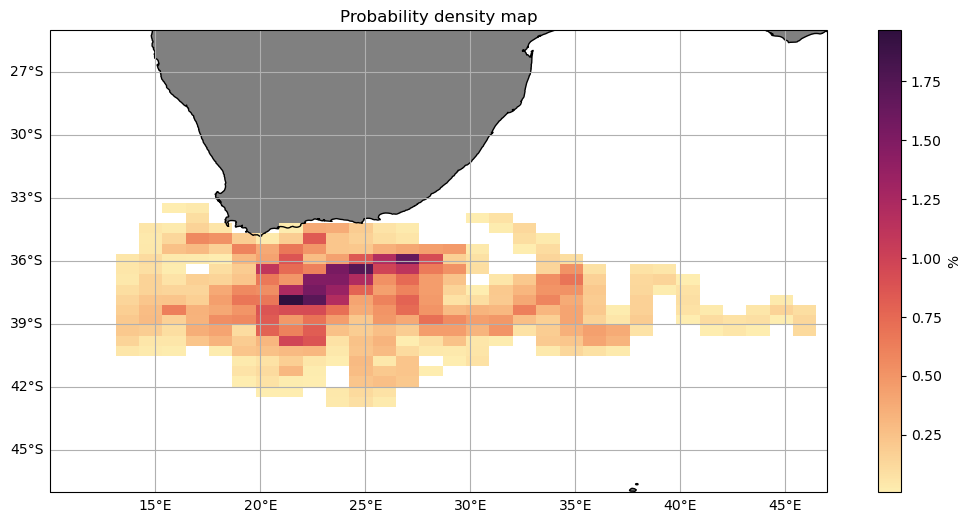

In [12]:
#choose the limits of the x & y axis of the graph
xlim=[10, 47]
ylim= [-47, -25]

#plot the results
probability_map(probability, xlim, ylim, 'Probability density map', None)

*optional: for very fine resolution regions, the original hydrodynamical data can be used to plot the pdf's results on top so that coast is better defined in space.